In [6]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as LA
from scipy import linalg as sLA

# Эволюция состояния:

In [7]:
def X():
    return np.array([[0,1],
                     [1,0]])
def Y():
    return np.array([[1,0],
                     [0,-1]])
def Z():
    return np.array([[0,-1j],
                     [1j,0]])

In [8]:
t0 = 0
t1 = 0.5

def H(t):
    H = 2*np.pi*(np.kron(X(),X()) + np.kron(Y(),Y())*np.sin(8*t))
    return H

def U(t,dt):
    return sLA.expm(-1j*H(t)*dt)

def F(rho1, rho2):
    return np.abs(np.trace(sLA.sqrtm(sLA.sqrtm(rho1) @ rho2 @ sLA.sqrtm(rho1))))**2

def get_rho(d,k):
    C_list = np.random.normal(0, 1, size=(d, k)) + 1j*np.random.normal(0, 1, size=(d, k))
    C_list = C_list/(np.sqrt(np.sum(C_list*np.conjugate(C_list))))
    C_list = np.reshape(C_list, [1,d,k,1])
    g_rho = np.tensordot(C_list, np.conjugate(C_list), [0,3])
    g_rho = np.reshape(g_rho, (d,k,d,k))
    rho = np.trace(g_rho, axis1=1, axis2=3)
    return rho

rho = get_rho(2,2)

rho, H(1), np.trace(rho), F(rho,rho)

(array([[0.83429216+9.19730407e-18j, 0.06119802+3.63374323e-01j],
        [0.06119802-3.63374323e-01j, 0.16570784-1.77507170e-18j]]),
 array([[ 6.2163212 ,  0.        ,  0.        ,  6.28318531],
        [ 0.        , -6.2163212 ,  6.28318531,  0.        ],
        [ 0.        ,  6.28318531, -6.2163212 ,  0.        ],
        [ 6.28318531,  0.        ,  0.        ,  6.2163212 ]]),
 (0.9999999999999999+7.422232368733085e-18j),
 0.9999999999999745)

In [9]:
def unitary_evolution(rho0, dt,t0 = 0, t1 = 0.5):
    t_list = []
    U_list = []
    rho_list = []
    F_list = []

    
    rho = rho0.copy()
#     rho = build_rho()
    rho_list.append(rho)
    F_list.append(F(rho, rho))
    t_list.append(t0)

    t = t0
    


    while t <= t1:
        U_list.append(U(t,dt))
        t += dt
        rho = np.dot(np.dot(U_list[-1],rho), U_list[-1].conj().T)
        t_list.append(t)
        rho_list.append(rho)
        F_list.append(F(rho, rho0))
        
    return t_list, F_list

    
def FonNeyman_evolution(rho0, dt, t0 = 0, t1 = 0.5):
    t_list = []
    F_list = []
    rho_list = []

#     rho0 = build_rho()

    t = t0
    rho = rho0.copy()


    while t <= t1:
        F_list.append(F(rho, rho0))
        t_list.append(t)
        rho_list.append(rho)
        rho += dt*(-1j*(H(t)@rho - rho@H(t)))
        t += dt

    return t_list, F_list

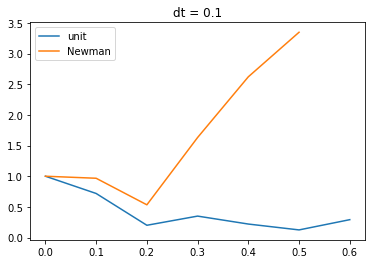

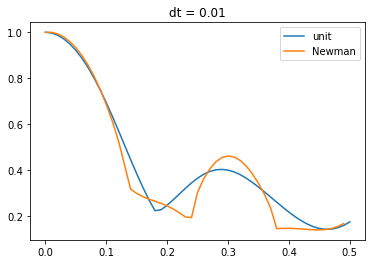

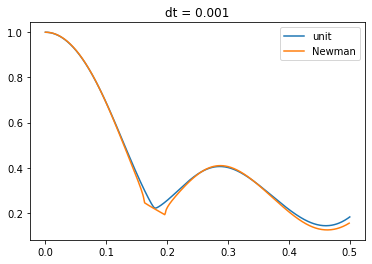

In [10]:
rho0 = get_rho(4,2)

for dt in [0.1, 0.01, 0.001]:
    t_unit, F_unit = unitary_evolution(rho0, dt = dt,t0 = 0, t1 = 0.5)
    t_newman, F_fonneyman = FonNeyman_evolution(rho0, dt = dt,t0 = 0, t1 = 0.5)
    fig, ax = plt.subplots()
    ax.set_title('dt = {}'.format(dt))
    ax.plot(t_unit, F_unit, label = 'unit')
    ax.plot(t_newman, F_fonneyman, label = 'Newman')
    plt.legend()
    plt.show()

По графикам видно, что унитарная эволюция описывает процесс точнее. При меньшей дискретности результаты остаются адекватными. При этом при высокой дискретности результаты практически совпадают.

# Часть 2.
# Амплитудно-фазовая релаксация:

In [11]:
t = 1
T0 = 7
T1 = 5

T2p = T0*T1/(2*T0-T1)

In [12]:
def gamma(t, T):
    return 1 - np.exp(-t/T)

E0 = np.array([[1,0],
              [0,np.sqrt(1 - gamma(t, T0))]])

E1 = np.array([[0,np.sqrt(gamma(t, T0))],
              [0,0]])

E2 = np.array([[1,0],
              [0,np.sqrt(1 - gamma(t, T2p))]])

E3 = np.array([[0,0],
              [0,np.sqrt(gamma(t, T2p))]]) 

kraus_list = [E0@E2, E0@E3, E1@E2, E1@E3]

In [13]:
S = 0
for E in kraus_list:
    S += E.conj().T@E
S

array([[1., 0.],
       [0., 1.]])

In [14]:
# Зададим состояние Ф = (|00> + |11>)/(2^(0.5))

phi = (1 / np.sqrt(2)) * np.array([1, 0, 0, 1], dtype=complex)
phi_tensor = phi.reshape(2, 2)

# Вычислм матрицу плотности состояния Ф

rho_phi_tensor = np.tensordot(phi_tensor.reshape(2, 2, 1).conjugate(), phi_tensor.reshape(1, 2, 2), axes=([2], [0]))

In [15]:
# Вычислим матрицу плотности через операторы Краусса

chi_matrix = np.zeros((4, 4), dtype=complex)
for kraus in kraus_list:
    chi_tensor_part_sum = np.tensordot(kraus, np.tensordot(rho_phi_tensor, kraus.T.conjugate(), axes=([3], [0])), axes=([1], [1]))
    chi_tensor_part_sum = np.transpose(chi_tensor_part_sum, axes=(1, 0, 2, 3))
    chi_matrix += 2 * chi_tensor_part_sum.reshape(4, 4)
print(chi_matrix)

[[1.        +0.j 0.        +0.j 0.        +0.j 0.81873075+0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.1331221 +0.j 0.        +0.j]
 [0.81873075+0.j 0.        +0.j 0.        +0.j 0.8668779 +0.j]]


In [16]:
# Вычислим частичный след Чи-матрицы по подсистеме:

chi_tensor = np.reshape(chi_matrix, [2, 2, 2, 2])
chi_partial_trace_2 = np.trace(chi_tensor, axis1=1, axis2=3)
print('Частичный след:')
print(chi_partial_trace_2)
print()
print('Как и ожидалось равен 1-ой матрице')


Частичный след:
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]

Как и ожидалось равен 1-ой матрице


In [17]:
# Вычислим Супероператор:

G = np.zeros((4, 4), dtype=complex)
for kraus in kraus_list:
    G += np.kron(np.conjugate(kraus), kraus)
    
print('Матрица Супероператора:')
print(G)

Матрица Супероператора:
[[1.        +0.j 0.        +0.j 0.        +0.j 0.1331221 +0.j]
 [0.        +0.j 0.81873075+0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.81873075+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.8668779 +0.j]]


In [18]:
# Зададим случайное состояние ранга 2:

d = 2
k = 2
rho0 = get_rho(d,k)

In [19]:
# Рассчитаем воздействие операторов Краусса на заданное состояние:

rho_final_kraus = np.zeros((2, 2), dtype=complex)
for kraus in kraus_list:
    rho_final_kraus += kraus @ rho0 @ kraus.T.conjugate()

print('Матрица плотности после воздействия рассматриваемого процесса:')
print()
print(rho_final_kraus)

Матрица плотности после воздействия рассматриваемого процесса:

[[ 0.75616779-1.34289415e-17j -0.02117063+2.02924619e-01j]
 [-0.02117063-2.02924619e-01j  0.24383221-1.30603350e-19j]]


In [20]:
def Chao_yam_evolution(rho0, chi_matrix):

    rho_final_chi = np.zeros((2, 2), dtype=complex)
    A_1 = np.array([[1, 0], 
                    [0, 0]], dtype=complex)
    A_2 = np.array([[0, 0], 
                    [1, 0]], dtype=complex)
    A_3 = np.array([[0, 1], 
                    [0, 0]], dtype=complex)
    A_4 = np.array([[0, 0], 
                    [0, 1]], dtype=complex)
    list_A = [A_1, A_2, A_3, A_4]
#     print(list_A)
    for i in range(4):
        for j in range(4):
            rho_final_chi += chi_matrix[i, j] * (list_A[i] @ rho0 @ list_A[j].T.conjugate())
            
    return rho_final_chi

def Super_oper_evolution(rho0, G):
    rho = np.reshape(rho0, -1, order='F').reshape((4, 1))
    return np.reshape(G @ rho, (2, 2), order='F')

rho_chi = Chao_yam_evolution(rho0, chi_matrix)
rho_super = Super_oper_evolution(rho0, G)

print('Матрица плотности, полученная с помощью Чи-матрицы:')
print(rho_chi)
print()

print('Матрица плотности, полученная с помощью супероператора:')
print(rho_super)

print('Матрица плотности, полученная с помощью операторов Краусса:')
print()
print(rho_final_kraus)

Матрица плотности, полученная с помощью Чи-матрицы:
[[ 0.75616779-1.34289415e-17j -0.02117063+2.02924619e-01j]
 [-0.02117063-2.02924619e-01j  0.24383221-1.30603350e-19j]]

Матрица плотности, полученная с помощью супероператора:
[[ 0.75616779-1.34289415e-17j -0.02117063+2.02924619e-01j]
 [-0.02117063-2.02924619e-01j  0.24383221-1.30603350e-19j]]
Матрица плотности, полученная с помощью операторов Краусса:

[[ 0.75616779-1.34289415e-17j -0.02117063+2.02924619e-01j]
 [-0.02117063-2.02924619e-01j  0.24383221-1.30603350e-19j]]


In [21]:
F(rho_chi, rho_super), F(rho_super, rho_final_kraus), F(rho_chi, rho_final_kraus)

(0.9999999999999998, 1.0, 0.9999999999999993)